In [1]:
import numpy as np
#import tensorflow as tf
from glob import glob
import os
from os.path import join,exists,basename
import json
import random
import pickle
import cv2 as cv
from natsort import natsorted
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-20 08:37:22.972831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 08:37:23.610179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cvlab/anaconda3/envs/vision/lib/python3.10/site-packages/cv2/../../lib64:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib:/usr/local/cuda-11.7/lib64${LD_LIBRARY_PATH:+:}
2023-02-20 08:37:23.610339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvin

In [2]:
random.seed(123)
np.random.seed(123)

In [3]:
### Information about directory src and target 
dires={'raw_videos':join('dataset_raw','smarthome_raw','alphapose','CD2','raw_video'),
'bboxs':join('dataset_raw','smarthome_raw','alphapose','CD2','bbox_pkl'),
'img_ids':join('datasets_features','smarthome','alphapose','CD2','img_id')}

In [4]:
rgb_target_dires={'co':join('datasets_features','smarthome','rgb','CD2'),
'cd':join('datasets_features','smarthome','CD2')
}

In [5]:
seq_len=42
w,h=640,480
co_classnames=natsorted(os.listdir(dires['img_ids']+'/train'))

In [6]:
co_classnames

['Drink.Fromcup', 'Readbook', 'Uselaptop', 'Usetelephone']

In [7]:
def crop_img(frame,bbox,h_req,w_req):
    x,y,w,h=bbox
    
    
    if h >= h_req:
        
        diff_h=int((h-h_req)/2)
        
        y=int(y+diff_h)
        y1=y+h_req


        while y >frame.shape[0]:
            height_diff=y-frame.shape[0]
            if height_diff==1:
                y1=y1-height_diff
                y=y-height_diff
            else:
                height_diff=int(np.floor((y-frame.shape[0])/2))
                y1=y1-height_diff
                y=y-height_diff
        
        
            
        #Adjusting if crop boundry goes out of frame (y1> original height)
        while y1 >frame.shape[0]:
            height_diff=y1-frame.shape[0]
            if height_diff==1:
                y1=y1-height_diff
                y=y-height_diff
            else:
                height_diff=int(np.floor((y1-frame.shape[0])/2))
                y1=y1-height_diff
                y=y-height_diff
        

    else:
        diff_h=int((h_req-h)/2)
        y=int(y-diff_h) ## Subtrating 
        y1=y+h_req
    
        # Adjusting if y1 becomes negative
        while y <0:
            height_diff=frame.shape[0]-y1
            if height_diff==1:
                y1=y1+height_diff
                y=y+height_diff
                
            else:
                height_diff=int(np.floor((frame.shape[0]-y1)/2)) ## Check Error if it is from here
                y1=y1+height_diff
                y=y+height_diff
            
        #Adjusting if crop boundry goes out of frame (y1> original height)
        while y1 >frame.shape[0]:
            height_diff=y1-frame.shape[0]
            if height_diff==1:
                y1=y1-height_diff
                y=y-height_diff
            else:
                height_diff=int(np.floor((y1-frame.shape[0])/2))
                y1=y1-height_diff
                y=y-height_diff    

    if w >= w_req:
        
        diff_h=int((w-w_req)/2)
        
        x=int(w+diff_h)
        x1=x+w_req

        
        while x >frame.shape[1]:
            w_diff=x-frame.shape[1]
            if w_diff==1:
                x1=x1-w_diff
                x=x-w_diff
            else:
                w_diff=int(np.floor((x-frame.shape[1])/2))
                x1=x1-w_diff
                x=x-w_diff


        
        while x1 >frame.shape[1]:
            w_diff=x1-frame.shape[1]
            if w_diff==1:
                x1=x1-w_diff
                x=x-w_diff
            else:
                w_diff=int(np.floor((x1-frame.shape[1])/2))
                x1=x1-w_diff
                x=x-w_diff



    
            #print('After  y :',y," y1 :",y1)    
    ## Adjusting width
    else:
        diff_w=(w_req-w)/2
        x=int(x-diff_w)
        #print(0)
        x1=x+w_req
        #print('x :',x," x1 :",x1)
        #Adjusting if crop boundry goes out of frame (x1> original width)
        
        while x <0:
            height_diff=frame.shape[1]-x1
            if height_diff==1:
                x1=x1+height_diff
                x=x+height_diff
                
            else:
                height_diff=int(np.floor((frame.shape[1]-x1)/2))
                x1=x1+height_diff
                x=x+height_diff
        
        
        while x1 >frame.shape[1]:
            w_diff=x1-frame.shape[1]
            if w_diff==1:
                x1=x1-w_diff
                x=x-w_diff
            else:
                w_diff=int(np.floor((x1-frame.shape[1])/2))
                x1=x1-w_diff
                x=x-w_diff
    # Cropping the 

    c_img=frame[y:y1,x:x1,:]

    # if c_img.shape != (h_req,w_req,3):
    #     print('Crop Img shape :',c_img.shape)
    return c_img

In [8]:
## Samples Frames  Function 

def get_sampled_frames(video_dire,img_id_list,resize=False):
    sampled_frames=[]
    cap=cv.VideoCapture(video_dire)
    for frame_number in img_id_list:
        cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
        sucess,frame=cap.read()
        if resize:
            frame=cv.resize(frame,(w,h))
        sampled_frames.append(frame)

    sampled_frames=np.array(sampled_frames)

    return sampled_frames

In [9]:
def get_sampled_cropped_frames(sampled_frames,bboxs,req_h,req_w):
    cropped_frames=[]

    for idx in range(len(sampled_frames)):
        frame=sampled_frames[idx]
        bbox=bboxs[idx]
        c_img=crop_img(frame,bbox,req_h,req_w)
        cropped_frames.append(c_img)

    cropped_frames=np.array(cropped_frames)
    return cropped_frames

In [10]:
# ## Pretrained_model


# def resnet(sampled_features):
#     pass

# def get_densenet121(resized_height=h,resized_width=w):
#     ## defining the DenseNet121 model pretrained with imagenet dataset
#     feature_extractor=tf.keras.applications.DenseNet121(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(resized_height,resized_width,3),
#     pooling='max',

# )
#     ##Defining the input size for single image                    
#     inputs=tf.keras.Input((resized_height,resized_width,3))
#     preprocessed=tf.keras.applications.densenet.preprocess_input(inputs)

#     ## Give features for each image
#     outputs=feature_extractor(preprocessed)
#     ## defining feature extractor model
#     model=tf.keras.Model(inputs,outputs,name='feature_extractor')
#     return model

# densenet_model=get_densenet121(350,350)   

In [11]:
def get_resnet152v2(resized_height=h,resized_width=w):
    ## defining the ResNet152V2 model pretrained with imagenet dataset
    feature_extractor=tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(resized_height,resized_width,3),
    pooling='max',
)
    ##Defining the input size for single image                    
    inputs=tf.keras.Input((resized_height,resized_width,3))
    preprocessed=tf.keras.applications.resnet_v2.preprocess_input(inputs)

    ## Give features for each image
    outputs=feature_extractor(preprocessed)
    ## defining feature extractor model
    model=tf.keras.Model(inputs,outputs,name='feature_extractor')
    return model


resnet_model=get_resnet152v2(300,300)

2023-02-20 08:37:35.204968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 08:37:35.235726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 08:37:35.235853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 08:37:35.236172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
resnet_model.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
Total params: 58,331,648
Trainable params: 58,187,904
Non-trainable params: 143,744
_________________________________________________________________


In [17]:
features=[]
labels=[]
evals=['train','test','val']
for eval in evals:
    for idx,classname in enumerate(co_classnames):
        img_id_dires=glob(join(dires['img_ids'],eval,classname)+'/*.npy')
        for num,img_id_dire in enumerate(img_id_dires):
            filename=basename(img_id_dire)
            video_filename=filename[:-3]+'mp4'
            bbox_filename=filename[:-3]+'pickle'
            video_dire=join(dires['raw_videos'],classname,video_filename)
            bbox_dire=join(dires['bboxs'],classname,bbox_filename)

            with open(bbox_dire,'rb') as f:
                bbox_info=pickle.load(f)
            
            img_id=np.load(img_id_dire)
            img_id=[int(i.split('.')[0])for i in img_id]
            bbox_info={'{}.jpg'.format(i):bbox_info['{}.jpg'.format(i)] for i in img_id}
            bboxs=list(bbox_info.values())
            sampled_frames=get_sampled_frames(video_dire,img_id,resize=False)
            cropped_frames=get_sampled_cropped_frames(sampled_frames,bboxs,300,300)
       
            feature=resnet_model.predict(cropped_frames)
            features.append(feature)
            labels.append(idx)

            target_folder=join(rgb_target_dires['co'],'Crop','resnet152','keypoints',eval,classname)

            img_folder=join(rgb_target_dires['co'],'Crop','resnet152','imgs',eval,classname)


            if not exists(target_folder):
                os.makedirs(target_folder)

            if not exists(img_folder):
                os.makedirs(img_folder)

            target_filedire=join(target_folder,filename)
            img_filedire=join(img_folder,filename)

            np.save(target_filedire,feature)

            np.save(img_filedire,cropped_frames)

         

        
features=np.array(features)
labels=np.array(labels)


2023-02-20 08:40:20.793853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


2/2 [==============================] - 0s 96ms/step


: 

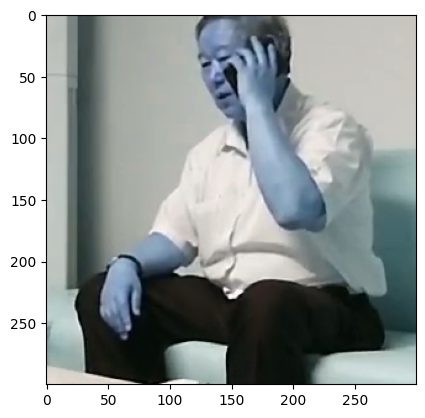

In [16]:
plt.imshow(cropped_frames[15])

In [ ]:
frame=sampled_frames[0]
bbox=bboxs[0]

In [ ]:
x,y,w,h=bbox

In [ ]:
w

In [ ]:
plt.imshow(c)

In [ ]:
video_dire

In [ ]:
img_id

In [ ]:
sampled_frames

In [ ]:
## Non Crop

features=[]
labels=[]
evals=['train','test','val']
for eval in evals:
    for idx,classname in enumerate(co_classnames):
        img_id_dires=glob(join(dires['img_ids'],eval,classname)+'/*.npy')
        for num,img_id_dire in enumerate(img_id_dires):
            filename=basename(img_id_dire)
            video_filename=filename[:-3]+'mp4'
            bbox_filename=filename[:-3]+'pickle'
            video_dire=join(dires['raw_videos'],classname,video_filename)
            bbox_dire=join(dires['bboxs'],classname,bbox_filename)

            with open(bbox_dire,'rb') as f:
                bbox_info=pickle.load(f)
            
            img_id=np.load(img_id_dire)
            img_id=[int(i.split('.')[0])for i in img_id]
            bbox_info={'{}.jpg'.format(i):bbox_info['{}.jpg'.format(i)] for i in img_id}
            bboxs=list(bbox_info.values())
            sampled_frames=get_sampled_frames(video_dire,img_id)
            #cropped_frames=get_sampled_cropped_frames(sampled_frames,bboxs,350,350)
            feature=resnet_model.predict(sampled_frames)
            features.append(feature)
            labels.append(idx)

            target_folder=join(rgb_target_dires['co'],'Non_Crop','resnet152','keypoints',eval,classname)

            

            if not exists(target_folder):
                os.makedirs(target_folder)

            

            target_filedire=join(target_folder,filename)
            

            np.save(target_filedire,feature)

        

            if (num%10 ==0):
                print('{}: {}'.format(classname,num))

        

        
features=np.array(features)
labels=np.array(labels)

In [ ]:
plt.imshow(cropped_frames[11])

In [ ]:
bbox=bbox_info['0.jpg']

In [ ]:
c_img=crop_img(test_frame,bbox,300,300)

In [ ]:
plt.imshow(c_img)

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
train_features, test_features, train_labels, test_labels=train_test_split(features, labels, test_size=0.25, random_state=101,stratify=labels)

In [ ]:

saved_dires_train=join(rgb_target_dires['co'],'Crop','densenet121','features','train')
if not os.path.exists(saved_dires_train):
    os.makedirs(saved_dires_train)

saved_dires_test=join(rgb_target_dires['co'],'Crop','densenet121','features','test')
if not os.path.exists(saved_dires_test):
    os.makedirs(saved_dires_test)

In [ ]:
np.save(join(saved_dires_train,'features.npy'),train_features)
np.save(join(saved_dires_train,'labels.npy'),train_labels)

np.save(join(saved_dires_test,'features.npy'),test_features)
np.save(join(saved_dires_test,'labels.npy'),test_labels)

In [ ]:
np.load(join(saved_dires_train,'labels.npy')).shape